##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

This is a sample code to assist you with vectorising the 'Train' dataset for your assignment 2.

First we read the CSV datafiles (Train and Test).

In [1]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/featurize/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/featurize/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/featurize/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud 
from collections import Counter


In [3]:
train_data = pd.read_csv("./data/Train.csv", sep=',')
test_data = pd.read_csv("./data/Test.csv", sep=',')


In [4]:
# observe a data record
print("Train data first 5 items: \n", train_data.iloc[:5, :])
print("Test data first 5 items: \n", test_data.iloc[:5, :])

Train data first 5 items: 
    Unnamed: 0                  id  \
0           2  805582613687713000   
1           3  637480203497832000   
2           4  641096279930507000   
3           5  625730917647126000   
4           6  633292370906230000   

                                                text sentiment  
0   doctors hit campaign trail as race to medical...   neutral  
1   is anybody going to the radio station tomorro...  positive  
2   i just found out naruto didn't become the 5th...   neutral  
3   "prince george reservist who died saturday ju...   neutral  
4   season in the sun versi nirvana rancak gak..s...  positive  
Test data first 5 items: 
                    id                                               text
0  802217876644052000   @loogunda @poroshenko putin abducted ukrainia...
1  802425296955682000   if putin wanted to intervene all he would hav...
2  805664502515662000   @hillbuzz @gaypatriot elsewhere in progland.....
3  639928670103015000   any females copp

##### Split train and test data, then we separate the tweet text and the label (sentiment). 
##### The Train.csv dataset is further splited into: Training dataset, and validation dataset. The officially provided test dataset will be used for evaluating each model on Kaggle 
##### __url__ HERE
##### Responsibilities of each dataset:
###### train_data works as the training dataset for the models.
###### validation_data works as the validation dataset for evaluating then **tuning** the model parameters.
###### Finally the test_data would be used as the testing dataset for evaluating the performance of our tuned models on Kaggle.

In [5]:
#separating instance and label for Train
X_train = [x[0] for x in train_data[['text']].values]
y_train = [x[0] for x in train_data[['sentiment']].values]
X_test = [x[0] for x in test_data[["text"]].values]

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size = 0.75)

Now each row is a list of tuples with the vector_id (word_id in the vocabulary) and the number of times it repeated in that given instance (tweet).

In [6]:

test_s = ["What da' heck, why'd i get such an a? He gets a lil bit drunk. you are a yogurt, yo. Listen to me, you needs to stop. Stop!! Gets out of my room, Errors should never pass silently."]
tokenizer = Tokenizer( oov_token='<??>')
tokenizer.fit_on_texts(test_s)
print(tokenizer.word_index)


{'<??>': 1, 'a': 2, 'gets': 3, 'you': 4, 'to': 5, 'stop': 6, 'what': 7, "da'": 8, 'heck': 9, "why'd": 10, 'i': 11, 'get': 12, 'such': 13, 'an': 14, 'he': 15, 'lil': 16, 'bit': 17, 'drunk': 18, 'are': 19, 'yogurt': 20, 'yo': 21, 'listen': 22, 'me': 23, 'needs': 24, 'out': 25, 'of': 26, 'my': 27, 'room': 28, 'errors': 29, 'should': 30, 'never': 31, 'pass': 32, 'silently': 33}


As we can tell, Tokenizer does do some lemmatisation job such as remove the tail punctuations for you. However, it's does not do the job of the rest of lemmatisation.

## ==== Preprocessing Toolkit ====
__Creating NLP preprocessing functions for later use__

In [7]:
def lemmatise_words(words:list):
    lemmatiser = WordNetLemmatizer()
    return [lemmatiser.lemmatize(w) for w in words]


In [8]:
def tokenise(texts):
    tokenizer = Tokenizer(oov_token="<?>")
    tokenizer.fit_on_texts(texts)

In [9]:
def no_nonalpha(words:list):
    out = []
    for w in words:
        word = ""
        for c in w:
            # print(c.isalpha())
            if c.isalpha():
                word+=c
        if len(word) > 0:
            out.append(word)
    return out

In [10]:
def to_lower(words:list):
    return [w.lower() for w in words]

In [11]:
def no_stop(words:list):
    s = stopwords.words('english')
    return [w for w in words if w not in s]

In [12]:
def wrangle(data, alpha_only = True, lemmatised = True, stop_removed = True, display_first =  0, visual = False):
    wrangled_out = []
    original_words = []
    lemmatised_words = []
    stop_removed_words = []
    for record in data:
        words = np.array(record.split())
        # to lower
        words = to_lower(words)
        if display_first > 0:
            print("Lower case: \n",words)
        # remove non-alphabetical words
        if alpha_only:
            words = no_nonalpha(words)
            if display_first > 0:
                print("Alphabets only: \n",words)
            for w in words:
                original_words.append(w)
        # lemmatisation
        if lemmatised:
            words = lemmatise_words(words)
            if display_first > 0:
                print("Lemmatised: \n", words)
            for w in words:
                lemmatised_words.append(w)
        # Remove stop words
        if stop_removed:
            words = no_stop(words)
            if display_first > 0:
                print("Stop words removed: \n",words)
            for w in words:
                stop_removed_words.append(w)
        wrangled_out.append(words)
        display_first -= 1
    # visualise use word cloud
    if visual:
        # non-alpha removed
        cloud = WordCloud(max_words=120, max_font_size=40, background_color="white")
        cloud.generate(" ".join(original_words))
        plt.figure(figsize=(16,16),dpi = 150)
        plt.title("WordCloud showing training data after non-alphabet phrases removal.")
        plt.imshow(cloud, alpha=0.9)

        # lemmatised_words
        cloud = WordCloud(max_words=120, max_font_size=40, background_color="white")
        cloud.generate(" ".join(lemmatised_words))
        plt.figure(figsize=(16,16),dpi = 150)
        plt.title("WordCloud showing training data after non-alphabet phrases removal, and lemmatisation.")
        plt.imshow(cloud, alpha=0.9)

        # stop removed
        cloud = WordCloud(max_words=120, max_font_size=40, background_color="white")
        cloud.generate(" ".join(stop_removed_words))
        plt.figure(figsize=(16,16),dpi = 150)
        plt.title("WordCloud showing training data after non-alphabet phrases removal, lemmatisation, and stopwords removal (sequential).")
        plt.imshow(cloud, alpha=0.9)
            
    return wrangled_out



# Preprocessing

Lemmatisation is done as the first step since it regulate stop words to their original form, serving for the following procesesing jobs.

In [14]:
wrangled_train = wrangle(X_train, alpha_only=True, display_first=0, visual = False)

### __Apply same wrangling to validation set and test set__

In [15]:
wrangled_validation = wrangle(X_validation, alpha_only=True, display_first=0, visual = False)
wrangled_test = wrangle(X_test, alpha_only=True,display_first=0, visual=False)

# __Random Forest__

__now fed the cleaned data into the TFIDF Vectorizer__

In [16]:
def get_tfidf_fit(dataset:list):
    flatten = []
    for s in dataset:
        flatten.append(" ".join(s))
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_fit = tfidf_vectorizer.fit(flatten)
    dict_vocab2id = tfidf_fit.vocabulary_
    dict_id2vocab = dict()
    for pair in dict_vocab2id.items():
        dict_id2vocab.update({pair[1]:pair[0]})
    return tfidf_fit, dict_id2vocab, dict_vocab2id

def act_tfidf_fit(dataset:list, tfidf_fit):
    flatten = []
    for s in dataset:
        flatten.append(" ".join(s))
    out = tfidf_fit.transform(flatten)
    return out

tfidf_fit, test_dict_id2vcab, test_dict_vocab2id  = get_tfidf_fit(wrangled_train)

# tfidf to all 3 datasets
tfidf_train = act_tfidf_fit(wrangled_train, tfidf_fit)
tfidf_validation = act_tfidf_fit(wrangled_validation, tfidf_fit)
tfidf_test = act_tfidf_fit(wrangled_test, tfidf_fit)

N_ESTIMATOR = 500
MIN_SAMPLES_LEAF = 2
BOOTSTRAP = True
OOB_SCORE = True


forest = RandomForestClassifier(
    n_estimators=N_ESTIMATOR, min_samples_leaf=MIN_SAMPLES_LEAF, bootstrap=BOOTSTRAP, oob_score=OOB_SCORE)
# forest.fit()
print(len(X_train))

16351


__Perform Randomforest on first run__

In [17]:
N_ESTIMATOR = 500
MIN_SAMPLES_LEAF = 2
BOOTSTRAP = True
OOB_SCORE = True

In [18]:
forest = RandomForestClassifier(
    n_estimators=N_ESTIMATOR, min_samples_leaf=MIN_SAMPLES_LEAF, bootstrap=BOOTSTRAP, oob_score=OOB_SCORE)

In [47]:
forest.fit(tfidf_train, y_train)

RandomForestClassifier(min_samples_leaf=2, n_estimators=500, oob_score=True)

In [294]:
print(f"RandomForest hyperparameters: \nN_ESTIMATOR = {N_ESTIMATOR}\nMIN_SAMPLES_LEAF = {MIN_SAMPLES_LEAF}\nBOOTSTRAP = {BOOTSTRAP}")
print(f"\nMean accuacy (on training data) of the first RandomForest Model: {forest.score(tfidf_train,y_train)}")
print(f"\nOOB score of the first RandomForst Model: {forest.oob_score_}")

RandomForest hyperparameters: 
N_ESTIMATOR = 500
MIN_SAMPLES_LEAF = 2
BOOTSTRAP = True

Mean accuacy (on training data) of the first RandomForest Model: 0.753898844107394

OOB score of the first RandomForst Model: 0.6416732921533851


__Tuning the Random Forest__

In [19]:
from sklearn.model_selection import GridSearchCV

forest_tuned = RandomForestClassifier()
N_ESTIMATORS = [10, 100, 500]
MAX_DEPTH = [10, 20, 50, None]
BOOTSTRAP = True
OOB_SCORE = True
params = {'n_estimators': N_ESTIMATORS, 'max_depth': MAX_DEPTH}

__!! LONG TIME WARNING BELOW CELL !!__

In [38]:
tuner = GridSearchCV(forest_tuned, params)
tuner.fit(tfidf_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 50, None],
                         'n_estimators': [10, 100, 500]})

__!! LONG TIME WARNING ABOVE CELL !!__

In [21]:
def disp_result(r):
    print('BEST PARAMS: {}\n'.format(r.best_params_))

    means = r.cv_results_['mean_test_score']
    stds = r.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, r.cv_results_['params']):
        print('{} for {}'.format(round(mean, 5) ,params))

# disp_result(tuner)

__TEST ON VALIDATION SET WITH THE CURRENT BEST PARAMs__

In [22]:
N_ESTIMATOR = 500
MIN_SAMPLES_LEAF = 2
BOOTSTRAP = True
OOB_SCORE = True


In [23]:
bestForest = RandomForestClassifier(
    n_estimators=N_ESTIMATOR, min_samples_leaf=MIN_SAMPLES_LEAF, bootstrap=BOOTSTRAP, oob_score=OOB_SCORE)

In [24]:
bestForest.fit(tfidf_train, y_train)

RandomForestClassifier(min_samples_leaf=2, n_estimators=500, oob_score=True)

In [25]:
y_validation_pred = np.array(bestForest.predict(tfidf_validation))

In [26]:
precision = round(precision_score(y_validation,y_validation_pred,average="weighted"), 5)
recall = round(recall_score(y_validation,y_validation_pred,average="weighted"),5)
accuracy = round(accuracy_score(y_validation,y_validation_pred), 5)
print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accuracy)


Precision:  0.65085
Recall:  0.65254
Accuracy:  0.65254


In [27]:
term_impact = pd.Series(bestForest.feature_importances_)
nlargest = term_impact.nlargest(40).items()
nlargestwords = dict()
for i in nlargest:
    nlargestwords.update({test_dict_id2vcab[i[0]] : i[1] })

nlargestwords = dict(sorted(nlargestwords.items(), key = lambda item: item[1]))

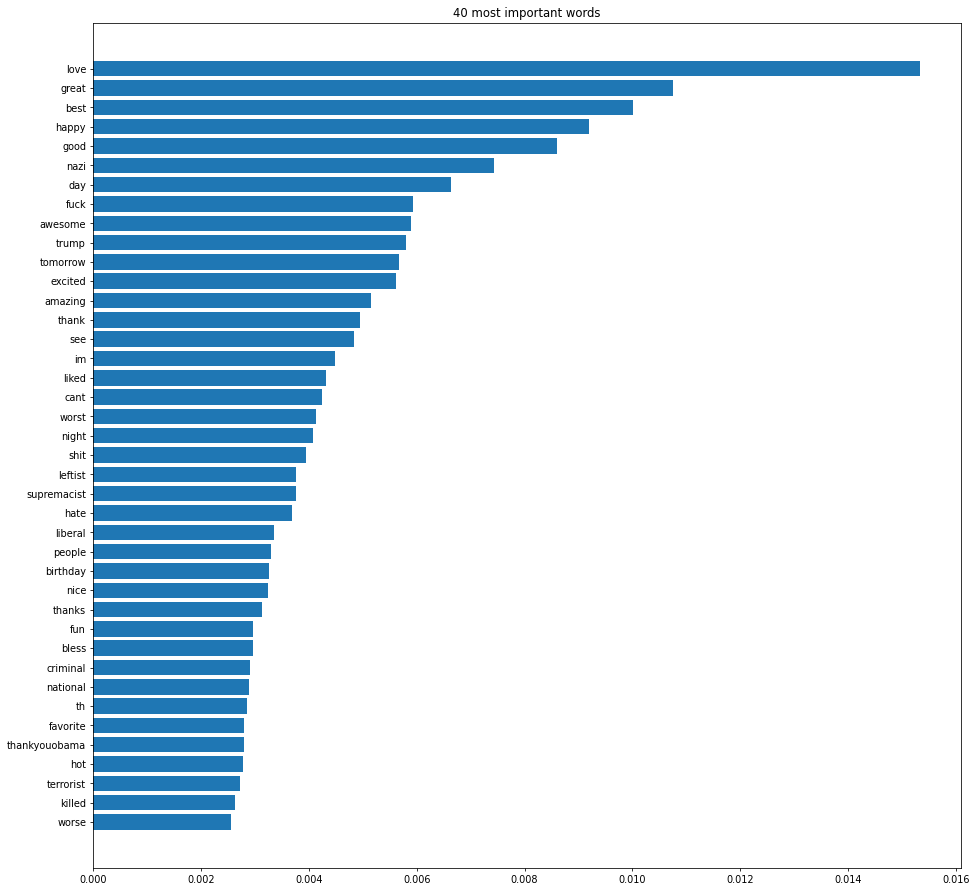

In [28]:

plt.figure(figsize=(16,16),dpi = 70)
plt.barh(list(nlargestwords.keys()), list(nlargestwords.values()))
plt.title("40 most important words")
plt.show()



__Build Nultidimential Random Forest Model using all data from train.csv, for maximising the performance__

In [148]:
train_data = pd.read_csv("./data/Train.csv", sep=',')
test_data = pd.read_csv("./data/Test.csv", sep=',')

#separating instance and label for Train
X = np.array([x[0] for x in train_data[['text']].values])
y = np.array([x[0] for x in train_data[['sentiment']].values])

X_RF = wrangle(X, alpha_only= True, lemmatised=True, stop_removed=True)

In [150]:
tfidf_fit, test_dict_id2vcab, test_dict_vocab2id  = get_tfidf_fit(X_RF)

# tfidf to all 3 datasets
tfidf_train = act_tfidf_fit(X_RF, tfidf_fit)

N_ESTIMATOR = 500
MIN_SAMPLES_LEAF = 2
BOOTSTRAP = True
OOB_SCORE = True


rf = RandomForestClassifier(
    n_estimators=N_ESTIMATOR, min_samples_leaf=MIN_SAMPLES_LEAF, bootstrap=BOOTSTRAP, oob_score=OOB_SCORE)




# __MULTIDIMENTIONAL NAIVE BAYES__

In [134]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from nltk.tokenize import SpaceTokenizer

In [146]:
train_data = pd.read_csv("./data/Train.csv", sep=',')
test_data = pd.read_csv("./data/Test.csv", sep=',')

#separating instance and label for Train
X = np.array([x[0] for x in train_data[['text']].values])
y = np.array([x[0] for x in train_data[['sentiment']].values])


In [136]:
X_NB = wrangle(X, alpha_only= True, lemmatised=True, stop_removed=True)


In [137]:
MAX_LENGTH_NB = 150

In [138]:
token = SpaceTokenizer()
cv = CountVectorizer(stop_words="english", ngram_range=(1,1), tokenizer=token.tokenize)
text_counts = cv.fit_transform([" ".join(t) for t in X_NB])

In [139]:
X_train_NB, X_validation_NB, y_train_NB, y_validation_NB = train_test_split(text_counts, y, train_size = 0.75)

In [144]:
clf = MultinomialNB()
clf.fit(X=X_train_NB, y = y_train_NB)

MultinomialNB()

In [145]:
y_pred_NB = clf.predict(X_validation_NB)

In [143]:
print("Accuracy: ", accuracy_score(y_validation_NB, y_pred_NB))
print("Precision: ", precision_score(y_validation_NB, y_pred_NB, average="weighted"))
print("Recall: ", recall_score(y_validation_NB, y_pred_NB, average="weighted"))
print("F1 Score: ", f1_score(y_validation_NB, y_pred_NB, average="weighted"))


Accuracy:  0.6154833975417354
Precision:  0.605895545712872
Recall:  0.6154833975417354
F1 Score:  0.6073272376458253


__Build Nultidimential Naive Bayes Model using all data from train.csv, for maximising the performance__

In [147]:
mnb = MultinomialNB()
mnb.fit(X=text_counts, y = y)

MultinomialNB()

# __Support Vector Machine__

In [226]:
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer

In [232]:
train_data = pd.read_csv("./data/Train.csv", sep=',')
test_data = pd.read_csv("./data/Test.csv", sep=',')

#separating instance and label for Train
X = np.array([x[0] for x in train_data[['text']].values])
y = np.array([x[0] for x in train_data[['sentiment']].values])

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size = 0.85)


In [265]:
X_train_SVM = [" ".join(s) for s in wrangle(X_train)]
X_validation_SVM =[" ".join(s) for s in wrangle(X_validation)]

tfidf_vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.7,
                             sublinear_tf = True,
                             use_idf = True)
train_v = tfidf_vectorizer.fit_transform(X_train_SVM)
validation_v =  tfidf_vectorizer.transform(X_validation_SVM)


In [266]:
from sklearn import svm
svm = svm.SVC(kernel = "linear")

In [267]:
svm.fit(train_v, y_train)

SVC(kernel='linear')

In [268]:
y_pred_SVM = svm.predict(validation_v)

In [269]:
print("Precision", precision_score(y_validation, y_pred_SVM, average = 'weighted'))
print("Accuracy", accuracy_score(y_validation, y_pred_SVM))
print("Precision", recall_score(y_validation, y_pred_SVM, average = 'weighted'))
print("f1-score", f1_score(y_validation, y_pred_SVM, average = 'weighted'))

Precision 0.6505897807552291
Accuracy 0.6594313665545705
Precision 0.6594313665545705
f1-score 0.6350989437999944


# __Recurrent Neural Network : Long Short Term Memory__

In [151]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [152]:
print("Average tweet length",np.mean([len(x) for x in X_train]))
print("Max tweet length",np.max([len(x) for x in X_train]))
print("0.95 Quantile tweet length",np.quantile([len(x) for x in X_train], 0.95))
print("0.99 Quantile tweet length",np.quantile([len(x) for x in X_train], 0.99))

Average tweet length 114.71139379854444
Max tweet length 1222
0.95 Quantile tweet length 143.0
0.99 Quantile tweet length 147.0


In [187]:
train_data = pd.read_csv("./data/Train.csv", sep=',')
test_data = pd.read_csv("./data/Test.csv", sep=',')

#separating instance and label for Train
X_train = np.array([x[0] for x in train_data[['text']].values])
y_train = np.array([x[0] for x in train_data[['sentiment']].values])

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size = 0.90)

In [188]:
X_train_LSTM = wrangle(X_train)
X_validation_LSTM = wrangle(X_validation)

In [189]:
tokeniser = Tokenizer( oov_token='<???>')
tokeniser.fit_on_texts(X_train_LSTM)

In [190]:
MAX_LEN = 150
TRUNCATING = 'post'
PADDING = 'post'
N_WORDS = tokeniser.word_index.__len__()


In [191]:
def to_seq(tokeniser, texts):
    seq = tokeniser.texts_to_sequences(texts)
    padded_texts = pad_sequences(seq, truncating = TRUNCATING, padding=PADDING, maxlen=MAX_LEN)
    return padded_texts

In [192]:
sent2idx_dict = dict((sentiment,idx) for idx, sentiment in enumerate(set(y_train)))
idx2sent_dict = dict((value,key) for key, value in sent2idx_dict.items())
def sent2idx(y_train):
    y_indeces = []
    for y in y_train:
        y_indeces.append(sent2idx_dict[y])
    return np.array(y_indeces)

def idx2sent(y_train):
    y_indeces = []
    for y in y_train:
        y_indeces.append(idx2sent_dict[y])
    return np.array(y_indeces)

    

In [193]:
lstm = tf.keras.models.Sequential([
tf.keras.layers.Embedding( N_WORDS,16,input_length=MAX_LEN),
tf.keras.layers.SpatialDropout1D(0.4),
tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
# tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Dense(3, activation='softmax')
])
lstm.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

In [194]:
seq_train = to_seq(tokenizer, X_train_LSTM)
seq_validation = to_seq(tokenizer,X_validation_LSTM)
y_train_idx = sent2idx(y_train)
y_validation_idx= sent2idx(y_validation)
lstm_fitted = lstm.fit(
     seq_train, y_train_idx,
     validation_data=(seq_validation, y_validation_idx),
     epochs=20,
     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)]
)

Epoch 1/20
614/614 [==============================] - 20s 28ms/step - loss: 0.9041 - accuracy: 0.6028 - val_loss: 0.7810 - val_accuracy: 0.6483
Epoch 2/20
614/614 [==============================] - 16s 26ms/step - loss: 0.7076 - accuracy: 0.6910 - val_loss: 0.7394 - val_accuracy: 0.6657
Epoch 3/20
614/614 [==============================] - 16s 26ms/step - loss: 0.5479 - accuracy: 0.7770 - val_loss: 0.7663 - val_accuracy: 0.6612


# __ENSEMBLE MODEL__
###### __[META]: Logistic Regression </br> [BASEs]: SVM, RandomForest, Multidimential Naive Bayes, LSTM__

In [270]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [281]:
clfs = [('svm', svm),('rf', rf),('mnb', mnb)]

In [282]:
stack = StackingClassifier(estimators = clfs, final_estimator= LogisticRegression())

In [284]:
X_train_stack = [" ".join(s) for s in wrangle(X_train)]
X_validation_stack =[" ".join(s) for s in wrangle(X_validation)]

tfidf_vectorizer = TfidfVectorizer()
train_v_stack = tfidf_vectorizer.fit_transform(X_train_stack)
validation_v_stack =  tfidf_vectorizer.transform(X_validation_stack)


In [283]:
stack.fit(train_v_stack,y_train)

/environment/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


StackingClassifier(estimators=[('svm', SVC(kernel='linear')),
                               ('rf',
                                RandomForestClassifier(min_samples_leaf=2,
                                                       n_estimators=500,
                                                       oob_score=True)),
                               ('mnb', MultinomialNB())],
                   final_estimator=LogisticRegression())

In [286]:
stack_pred = stack.predict(validation_v_stack)

In [287]:

print("Precision", precision_score(y_validation, stack_pred, average = 'weighted'))
print("Accuracy", accuracy_score(y_validation, stack_pred))
print("Precision", recall_score(y_validation, stack_pred, average = 'weighted'))
print("f1-score", f1_score(y_validation, stack_pred, average = 'weighted'))

Precision 0.6529190669550127
Accuracy 0.6618771018037297
Precision 0.6618771018037297
f1-score 0.650163382536137


In [289]:
X_test_stack =[" ".join(s) for s in wrangle(X_test)]
test_v_stack =  tfidf_vectorizer.transform(X_validation_stack)
pred_test_stack = stack.predict(test_v_stack)